# Load Data

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

import random

In [2]:
#!pip install pickle5 &> /dev/null
#import pickle5 as pickle

In [3]:
train_data = pd.read_csv('../input/subway-run-2/meta_data.csv')
display(train_data.head())

,image,label
0,Jump/100_run101.png,Jump
1,Jump/100_run6.png,Jump
2,Jump/100_run7.png,Jump
3,Jump/101_run101.png,Jump
4,Jump/101_run6.png,Jump


In [4]:
train_data.label.value_counts()

Left       7904
Right      7874
Nothing    7001
Jump       3505
Roll       1612
Name: label, dtype: int64

In [5]:
#train_data = train_data[train_data.label != 'Nothing']

In [6]:
def get_path(image_id):
    """adding the main path with the image paths"""
    
    return "../input/subway-run-2/{}".format(image_id)

In [7]:
train_data['path'] = train_data['image'].apply(get_path)

# Directory

In [8]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Config

In [9]:
# ====================================================
# CFG
# ====================================================
class CFG: #the configuration where all parameters/hyperparameters are stored
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name = 'resnet18'
    size=224
    scheduler='CosineAnnealingWarmRestarts' 
    criterion='CrossEntropyLoss' 
    epochs=10
    T_0=10 
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed = 42
    target_size = 5
    target_col = 'label'
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True
    smoothing = 0.05
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master') #using rossman's timm package

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [11]:
def get_score(y_true, y_pred):
    """ function to calculate accuracy"""
    
    return accuracy_score(y_true, y_pred)

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    """for logging the training steps"""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed = 42):
    """to maintain reproducability"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.seed)

# CV Split

In [12]:
def encode_target(row):
    if row == 'Jump':
        row = 0
    elif row == 'Left':
        row = 1
    elif row == 'Right':
        row = 2
    elif row == 'Roll':
        row = 3
    else:
        row = 4
    return row

train_data['label'] = train_data['label'].apply(encode_target)

In [13]:
# making a 5 fold split
folds = train_data.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         701
      1        1581
      2        1575
      3         322
      4        1401
1     0         701
      1        1581
      2        1575
      3         322
      4        1400
2     0         701
      1        1581
      2        1575
      3         322
      4        1400
3     0         701
      1        1581
      2        1574
      3         323
      4        1400
4     0         701
      1        1580
      2        1575
      3         323
      4        1400
dtype: int64


# Dataset

In [14]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

(224, 224, 3)


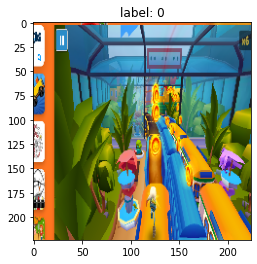

(224, 224, 3)


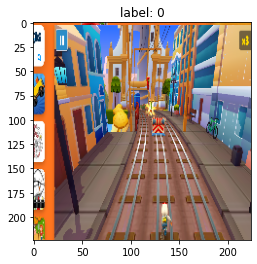

In [15]:
train_dataset = TrainDataset(train_data, transform=None)

for i in range(2):
    image, label = train_dataset[i]
    print(image.shape)
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show()

# Transforms

In [16]:
# all the augmentations are defined here here
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
#             A.RandomResizedCrop(CFG.size, CFG.size),
#             A.ColorJitter(p=0.5),
#             A.HueSaturationValue(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

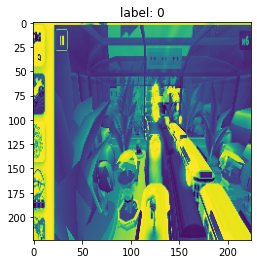

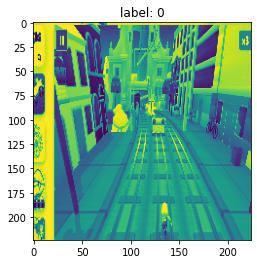

In [17]:
train_dataset = TrainDataset(train_data, transform = get_transforms(data='train'))

for i in range(2):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

# Model

In [18]:
# ====================================================
# MODEL 
# ====================================================
class CustomNet(nn.Module):
    """ using the resnet arch and modifying the final classification head"""
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
model = CustomNet(model_name=CFG.model_name, pretrained=False) 
train_dataset = TrainDataset(train_data, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0268,  0.2526, -0.1270,  0.2582,  0.1262],
        [ 0.1179,  0.3469, -0.0150,  0.2675,  0.0963],
        [-0.0409,  0.1456, -0.1575,  0.2992,  0.0416],
        [-0.0081,  0.1440, -0.0646,  0.3452,  0.1829]],
       grad_fn=<AddmmBackward0>)


# Helper Functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    """ convert to minutes"""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """keep a tarck of time"""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """the main train function is defined here, gradient clipping is done and final loss average is returned"""
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    """ the validation fucntion that returns the average validation loss and the prediction probability for each class(through softmax)"""
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train Loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        """ function that gets the scheduler"""
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomNet(CFG.model_name, pretrained=True)
    
    model.to(device) #move to gpu if available

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)
        
    
    def get_criterion():
        """ get the loss function """
        if CFG.criterion=='CrossEntropyLoss':
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion=='LabelSmoothing':
            criterion = LabelSmoothingLoss(classes=CFG.target_size, smoothing=CFG.smoothing)
        return criterion


    # ====================================================
    # loop 
    # ====================================================
    criterion = get_criterion()
    LOGGER.info(f'Criterion: {criterion}')

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau): 
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1)) #use the argmax to get the highest index label and calculate accuracy

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score: #if the curr score is better than previous best, save and replace the best score
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train: #also making an out of fold dataframe for every prediction we make
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [ ]:
if __name__ == '__main__': #The entry point for the program to run
    main()

========== fold: 0 training ==========
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
Criterion: CrossEntropyLoss()


Epoch: [1][0/697] Data 0.645 (0.645) Elapsed 0m 7s (remain 91m 53s) Loss: 1.4957(1.4957) Grad: 7.2434  
Epoch: [1][100/697] Data 0.000 (0.062) Elapsed 0m 21s (remain 2m 4s) Loss: 0.8813(1.1287) Grad: 6.4466  
Epoch: [1][200/697] Data 0.051 (0.066) Elapsed 0m 35s (remain 1m 27s) Loss: 0.5451(0.9394) Grad: 5.5424  
Epoch: [1][300/697] Data 0.000 (0.066) Elapsed 0m 48s (remain 1m 4s) Loss: 0.7535(0.8382) Grad: 6.9672  
Epoch: [1][400/697] Data 0.002 (0.066) Elapsed 1m 3s (remain 0m 46s) Loss: 0.5144(0.7653) Grad: 5.7563  
Epoch: [1][500/697] Data 0.000 (0.065) Elapsed 1m 16s (remain 0m 29s) Loss: 0.4806(0.7035) Grad: 6.8639  
Epoch: [1][600/697] Data 0.000 (0.065) Elapsed 1m 30s (remain 0m 14s) Loss: 0.4716(0.6596) Grad: 5.2415  
Epoch: [1][696/697] Data 0.000 (0.064) Elapsed 1m 44s (remain 0m 0s) Loss: 0.5458(0.6243) Grad: 7.3247  
EVAL: [0/175] Data 0.670 (0.670) Elapsed 0m 0s (remain 2m 1s) Loss: 0.4794(0.4794) 
EVAL: [100/175] Data 0.273 (0.108) Elapsed 0m 13s (remain 0m 9s) Loss: 0.0

Epoch 1 - avg_train_loss: 0.6243  avg_val_loss: 0.3517  time: 127s
Epoch 1 - Accuracy: 0.8686379928315412
Epoch 1 - Save Best Score: 0.8686 Model


EVAL: [174/175] Data 0.000 (0.106) Elapsed 0m 22s (remain 0m 0s) Loss: 0.1508(0.3517) 
Epoch: [2][0/697] Data 0.544 (0.544) Elapsed 0m 0s (remain 8m 1s) Loss: 0.2894(0.2894) Grad: 5.1089  
Epoch: [2][100/697] Data 0.133 (0.035) Elapsed 0m 12s (remain 1m 12s) Loss: 0.1837(0.2119) Grad: 3.6388  
Epoch: [2][200/697] Data 0.003 (0.033) Elapsed 0m 24s (remain 0m 59s) Loss: 0.0961(0.2052) Grad: 3.5885  
Epoch: [2][300/697] Data 0.111 (0.032) Elapsed 0m 36s (remain 0m 47s) Loss: 0.1997(0.1954) Grad: 6.2689  
Epoch: [2][400/697] Data 0.027 (0.031) Elapsed 0m 47s (remain 0m 35s) Loss: 0.2925(0.1986) Grad: 5.8466  
Epoch: [2][500/697] Data 0.000 (0.031) Elapsed 1m 0s (remain 0m 23s) Loss: 0.1440(0.2008) Grad: 4.0822  
Epoch: [2][600/697] Data 0.000 (0.029) Elapsed 1m 11s (remain 0m 11s) Loss: 0.2067(0.2049) Grad: 5.9353  


In [ ]:
oof_df = pd.read_csv('./oof_df.csv')
oof_df